In [ ]:
!pip install open3d

In [ ]:
import numpy as np
import cv2
import os
import open3d as o3d
import random
import time
from matplotlib import pyplot as plt
from google.colab import drive

In [ ]:
# Accessing My Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = os.getcwd() + '/drive/My Drive/My Final Year Project/Training data/'

In [ ]:
# Load the depth images
path_to_depth_image_raw = path + 'depth_image_raw.npy'
depth_image_raw = np.load(file=path_to_depth_image_raw)

In [ ]:
# Load the depth image
path_to_depth_image = path + 'single_depth_image.npy'
depth_image = np.load(file=path_to_depth_image)

In [ ]:
fx = 223.9940010790056
fy = 223.61783486959376
cx = 170.7684322973841
cy = 128.18711828338436

# camera matrix
K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]])

# distotion coefficients
k1 = -0.033904378348448685
k2 = -0.01537260902537579
k3 = -0.022284741346941413
k4 = 0.0069204143687187645

distCoeffs = np.array([k1, k2, k3, k4])
# Identify ground plane points (example: depth thresholding)
ground_mask = depth_image < 10 #42.89217  # Adjust the threshold as needed

# Extract 3D ground plane points
rows, cols = np.where(ground_mask)
depth_values = depth_image[rows, cols]
points_2d = np.stack((cols, rows), axis=1)
points_3d = np.zeros((len(rows), 3))
points_3d[:, 0] = (points_2d[:, 0] - cx) * depth_values / fx
points_3d[:, 1] = (points_2d[:, 1] - cy) * depth_values / fy
points_3d[:, 2] = depth_values

# Estimate ground plane parameters
centroid = np.mean(points_3d, axis=0)
points_centered = points_3d - centroid
covariance_matrix = np.dot(points_centered.T, points_centered)
_, _, v = np.linalg.svd(covariance_matrix)
plane_normal = v[-1, :]

# Determine camera extrinsic parameters
_, rvec, tvec, _ = cv2.solvePnPRansac(points_3d.astype(dtype=np.float32), points_2d.astype(dtype=np.float32), K.astype(dtype=np.float32), distCoeffs.astype(dtype=np.float32), useExtrinsicGuess=False)
rmat, _ = cv2.Rodrigues(src = rvec)

In [ ]:
from mpl_toolkits.mplot3d import proj3d

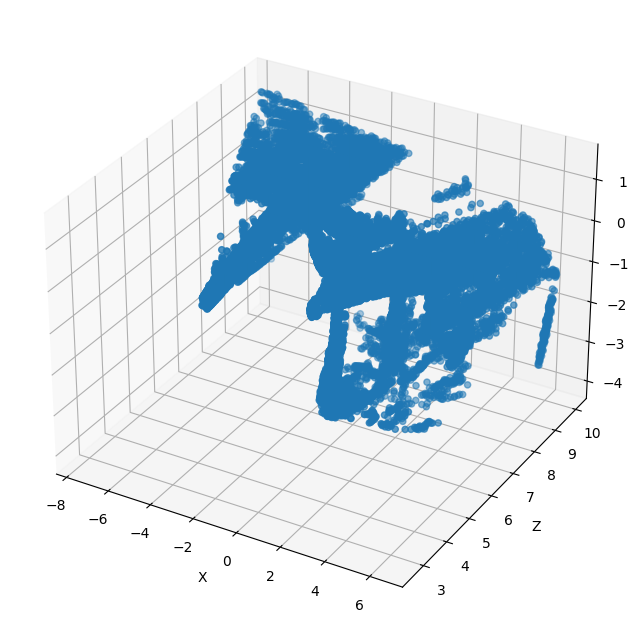

In [ ]:
x = points_3d[:, 0]
y = points_3d[:, 1]
z = points_3d[:, 2]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, z, y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

plt.show()

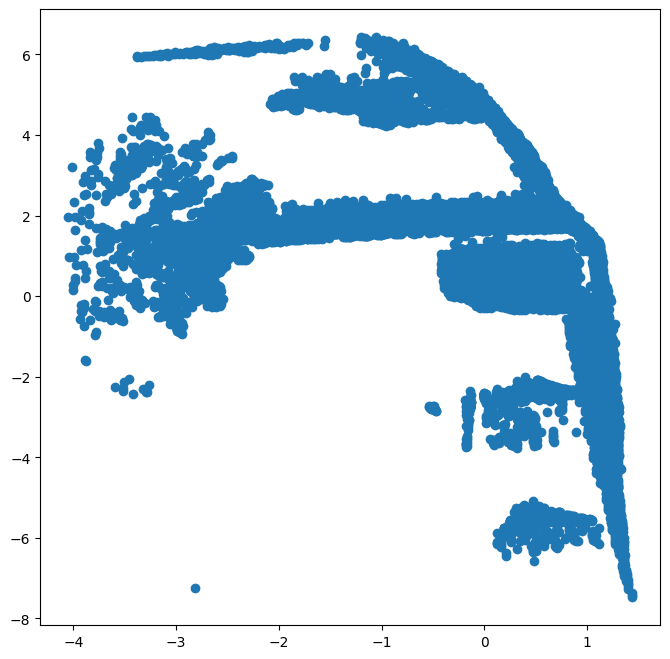

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

ax.scatter(y, x)
plt.show()

In [ ]:
# This code snippet was found here and modified to work here: https://github.com/yuecideng/Multiple_Planes_Detection
def NumpyToPCD(xyz):
    """ convert numpy ndarray to open3D point cloud 

    Args:
        xyz (ndarray): 

    Returns:
        [open3d.geometry.PointCloud]: 
    """

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)

    return pcd

def PCDToNumpy(pcd):
    """  convert open3D point cloud to numpy ndarray

    Args:
        pcd (open3d.geometry.PointCloud): 

    Returns:
        [ndarray]: 
    """

    return np.asarray(pcd.points)

def RemoveNoiseStatistical(pc, nb_neighbors=20, std_ratio=2.0):
    """ remove point clouds noise using statitical noise removal method

    Args:
        pc (ndarray): N x 3 point clouds
        nb_neighbors (int, optional): Defaults to 20.
        std_ratio (float, optional): Defaults to 2.0.

    Returns:
        [ndarray]: N x 3 point clouds
    """

    pcd = NumpyToPCD(pc)
    cl, ind = pcd.remove_statistical_outlier(
        nb_neighbors=nb_neighbors, std_ratio=std_ratio)

    return PCDToNumpy(cl)

def DownSample(pts, voxel_size=0.003):
    """ down sample the point clouds

    Args:
        pts (ndarray): N x 3 input point clouds
        voxel_size (float, optional): voxel size. Defaults to 0.003.

    Returns:
        [ndarray]: 
    """

    p = NumpyToPCD(pts).voxel_down_sample(voxel_size=voxel_size)

    return PCDToNumpy(p)


def PlaneRegression(points, threshold=0.01, init_n=3, iter=1000):
    """ plane regression using ransac

    Args:
        points (ndarray): N x3 point clouds
        threshold (float, optional): distance threshold. Defaults to 0.003.
        init_n (int, optional): Number of initial points to be considered inliers in each iteration
        iter (int, optional): number of iteration. Defaults to 1000.

    Returns:
        [ndarray, List]: 4 x 1 plane equation weights, List of plane point index
    """

    pcd = NumpyToPCD(points)

    w, index = pcd.segment_plane(
        threshold, init_n, iter)

    return w, index

def DrawResult(points, colors):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_plotly([pcd]) 
    #o3d.visualization.draw_geometries([pcd])


def DetectMultiPlanes(points, min_ratio=0.05, threshold=0.01, iterations=1000):
    """ Detect multiple planes from given point clouds

    Args:
        points (np.ndarray): 
        min_ratio (float, optional): The minimum left points ratio to end the Detection. Defaults to 0.05.
        threshold (float, optional): RANSAC threshold in (m). Defaults to 0.01.

    Returns:
        [List[tuple(np.ndarray, List)]]: Plane equation and plane point index
    """

    plane_list = []
    N = len(points)
    target = points.copy()
    count = 0

    while count < (1 - min_ratio) * N:
        w, index = PlaneRegression(
            target, threshold=threshold, init_n=3, iter=iterations)
    
        count += len(index)
        plane_list.append((w, target[index]))
        target = np.delete(target, index, axis=0)

    return plane_list

In [ ]:
results = DetectMultiPlanes(points=points_3d, threshold=0.001, iterations=2000)

In [ ]:
planes = []
colors = []
for _, plane in results:
    r = random.random()
    g = random.random()
    b = random.random()

    color = np.zeros((plane.shape[0], plane.shape[1]))
    color[:, 0] = r
    color[:, 1] = g
    color[:, 2] = b

    planes.append(plane)
    colors.append(color)

planes = np.concatenate(planes, axis=0)
colors = np.concatenate(colors, axis=0)
DrawResult(planes, colors)

In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d)
o3d.visualization.draw_plotly([pcd], width=800, height=600)